# Motivation Figures: Baseline System Limitations

We focus on two practical issues in baseline routing for multi-agent systems:
1. **Resource underutilization from imbalanced routing** — some models stay idle while others get overloaded, which increases queueing and role latency.
2. **Rigid synchronization overhead** — a slow agent can dominate end-to-end workflow time, leaving other agents waiting (idle slack).



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 11
# Load data
from pathlib import Path
DATA_PATH = Path('../logs/motivation_plot_generator_data/baseline_motivation_sweep_with_slack_10_100_400.csv')
if not DATA_PATH.exists():
    DATA_PATH = Path('logs/motivation_plot_generator_data/baseline_motivation_sweep_with_slack_10_100_400.csv')
df = pd.read_csv(DATA_PATH)
# Separate episode and step records
episode_df = df[df.record_type == 'episode'].copy()
step_df = df[df.record_type == 'step'].copy()
# Ensure numeric columns are numeric when available
for _col in [
    'arrival_rate',
    'workflow_latency_seconds',
    'workflow_slack_seconds',
    'wave_slack_seconds',
    'wave_max_latency_seconds',
    'latency_seconds',
    'llm_queue_avg',
    'round_index',
    'wave_index',
    'wave_size',
]:
    if _col in episode_df.columns:
        episode_df[_col] = pd.to_numeric(episode_df[_col], errors='coerce')
    if _col in step_df.columns:
        step_df[_col] = pd.to_numeric(step_df[_col], errors='coerce')
# Create short model names for plotting
model_name_map = {
    'Qwen/Qwen2.5-Coder-14B-Instruct': 'Qwen-14B',
    'mistralai/Mistral-Small-24B-Instruct-2501': 'Mistral-24B',
    'meta-llama/Llama-3.2-3B-Instruct': 'Llama-3B',
    'meta-llama/Llama-3.1-8B-Instruct': 'Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B': 'DeepSeek-32B'
}
step_df.loc[:, 'model_short'] = step_df['llm_name'].map(model_name_map)
# Drop any steps with unmapped model names (defensive)
step_df = step_df[step_df['model_short'].notna()].copy()
# Drop any workflows missing some arrival rates (require each item_id to exist for all rates)
arrival_rates_all = sorted(episode_df['arrival_rate'].dropna().unique())
if arrival_rates_all:
    rates_per_item = (
        episode_df.dropna(subset=['arrival_rate'])
        .groupby('item_id')['arrival_rate']
        .nunique()
    )
    complete_item_ids = rates_per_item[rates_per_item == len(arrival_rates_all)].index
    dropped_items = int(rates_per_item.shape[0] - len(complete_item_ids))
    episode_df = episode_df[episode_df['item_id'].isin(complete_item_ids)].copy()
    step_df = step_df[step_df['item_id'].isin(complete_item_ids)].copy()
    if dropped_items:
        print(f'Dropped {dropped_items} item_id(s) missing some arrival rates')
arrival_rates = sorted(step_df['arrival_rate'].dropna().unique())
model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']
models_in_data = [m for m in model_order if m in set(step_df['model_short'].unique())]
print(f'Total episode records: {len(episode_df)}')
print(f'Unique workflows (item_id): {episode_df["item_id"].nunique()}')
print(f'Total LLM calls (steps): {len(step_df)}')
print(f'Arrival rates: {arrival_rates}')
print(f'Models: {models_in_data}')


Dropped 1 item_id(s) missing some arrival rates
Total episode records: 1497
Unique workflows (item_id): 499
Total LLM calls (steps): 7955
Arrival rates: [np.float64(10.0), np.float64(100.0), np.float64(400.0)]
Models: ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']


## Issue 1: Resource Underutilization (Imbalanced Routing)

### Table 1: Query Distribution by Model and Arrival Rate
Counts and percentages show how workload concentrates on a subset of models.



In [37]:
from IPython.display import display

model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']
model_order = [m for m in model_order if m in set(step_df['model_short'].unique())]

# Query distribution by arrival rate (counts + %)
query_counts = (
    step_df.groupby(['arrival_rate', 'model_short'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=model_order, fill_value=0)
    .sort_index()
)
query_pct = query_counts.div(query_counts.sum(axis=1), axis=0) * 100.0

summary_table = pd.concat({'count': query_counts, 'pct': query_pct.round(2)}, axis=1)
summary_table = summary_table.swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)
summary_table.index.name = 'arrival_rate (request/second)'

display(summary_table)



model_short                   DeepSeek-32B       Llama-3B        Llama-8B  \
                                     count   pct    count    pct    count   
arrival_rate (request/second)                                               
10.0                                   130  4.94      720  27.38      767   
100.0                                  138  5.12      755  28.01      849   
400.0                                  119  4.52      754  28.67      786   

model_short                          Mistral-24B        Qwen-14B         
                                 pct       count    pct    count    pct  
arrival_rate (request/second)                                            
10.0                           29.16         786  29.89      227   8.63  
100.0                          31.50         709  26.31      244   9.05  
400.0                          29.89         692  26.31      279  10.61

### Figure 1: Role Latency by Model Across Arrival Rates
Average per-role latency, split by model, across arrival rates.



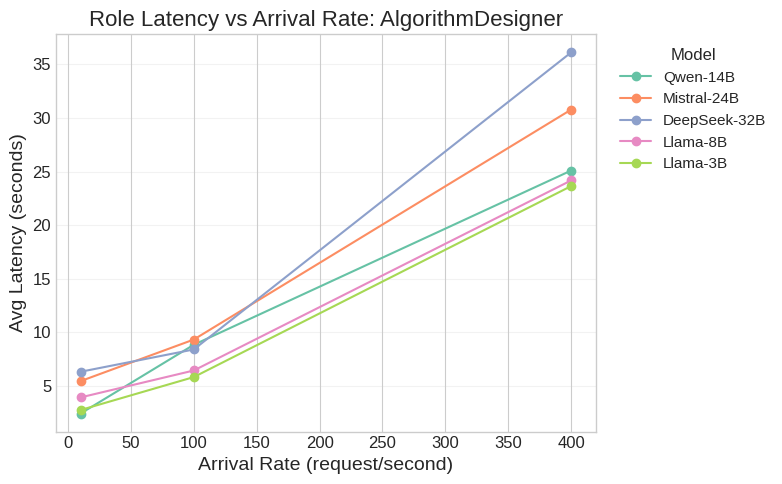

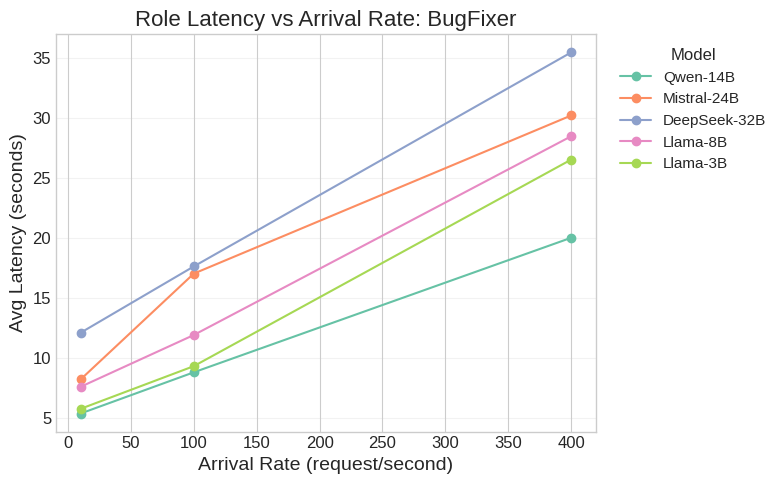

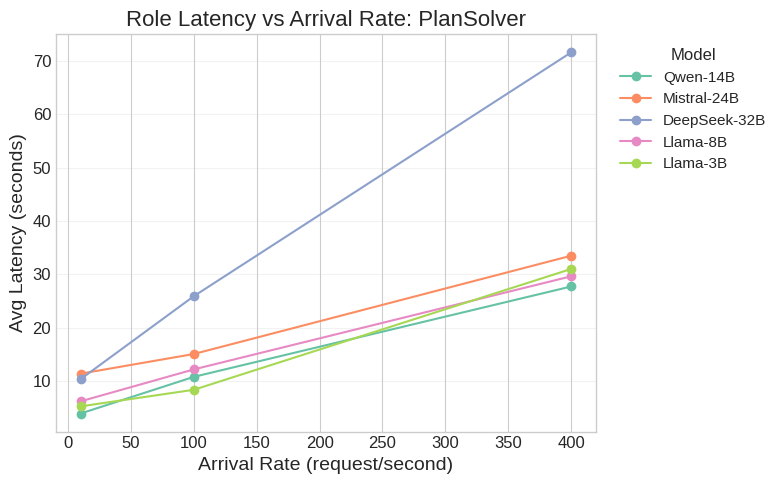

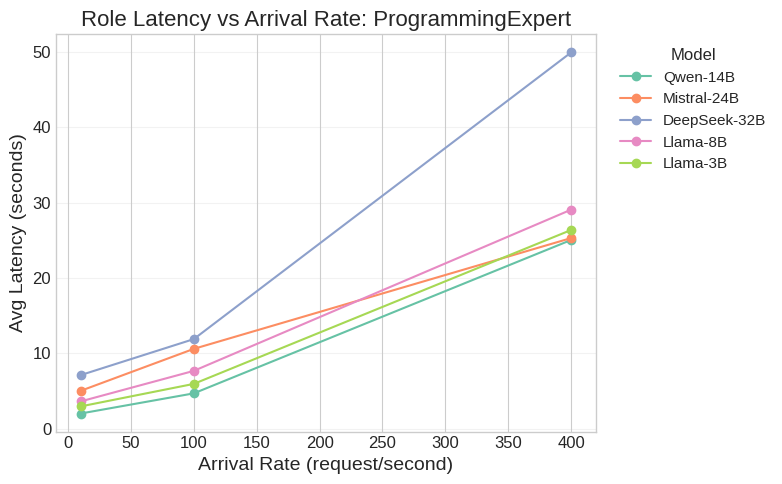

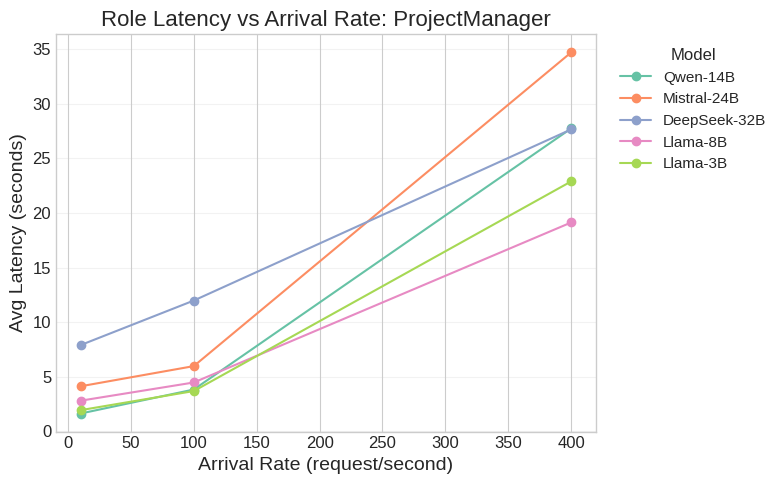

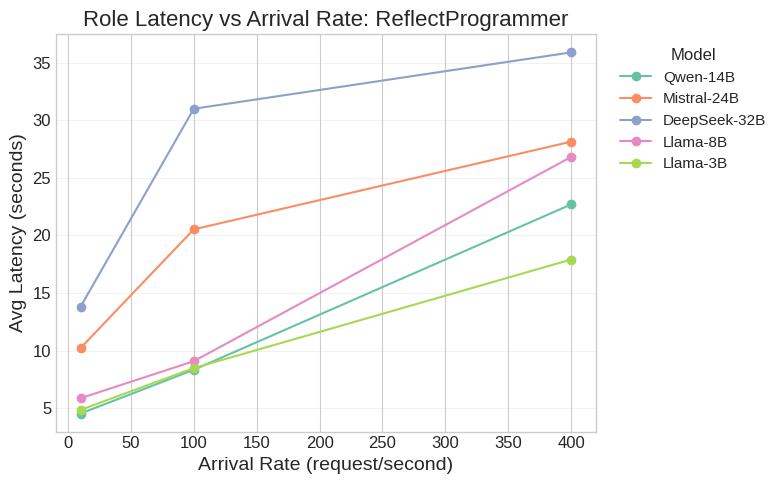

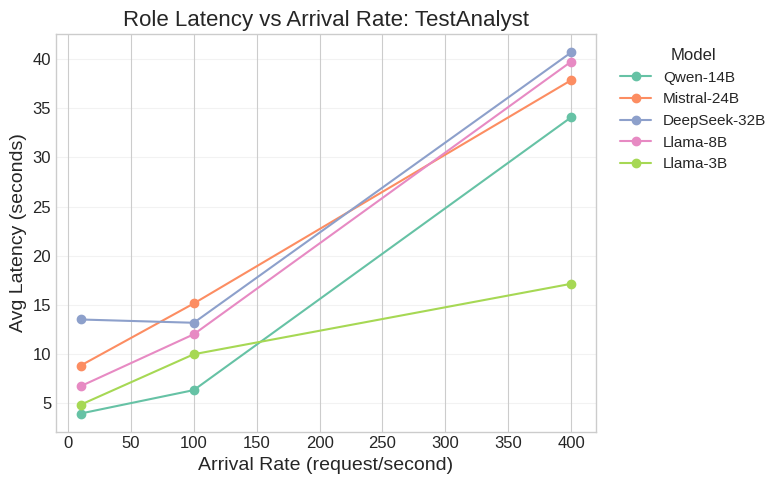

In [38]:
role_latency = (
    step_df.groupby(['role_name', 'model_short', 'arrival_rate'])['latency_seconds']
    .mean()
    .reset_index()
)
role_latency = role_latency.dropna(subset=['role_name'])

roles = sorted(role_latency['role_name'].unique())
model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']
model_order = [m for m in model_order if m in set(role_latency['model_short'].unique())]
colors = sns.color_palette('Set2', n_colors=len(model_order))

for role in roles:
    role_data = role_latency[role_latency['role_name'] == role]
    if role_data.empty:
        continue

    fig, ax = plt.subplots(figsize=(8, 5))
    for i, model in enumerate(model_order):
        model_data = role_data[role_data['model_short'] == model].sort_values('arrival_rate')
        if model_data.empty:
            continue
        ax.plot(
            model_data['arrival_rate'],
            model_data['latency_seconds'],
            marker='o',
            linewidth=1.5,
            label=model,
            color=colors[i],
        )

    ax.set_xlabel('Arrival Rate (request/second)')
    ax.set_ylabel('Avg Latency (seconds)')
    ax.set_title(f'Role Latency vs Arrival Rate: {role}')
    ax.legend(title='Model', loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.grid(True, axis='y', alpha=0.25)

    plt.tight_layout()
    plt.show()



### Figure 2: Queue Size by Arrival Rate
Average queue size when queue is present (queue > 0).



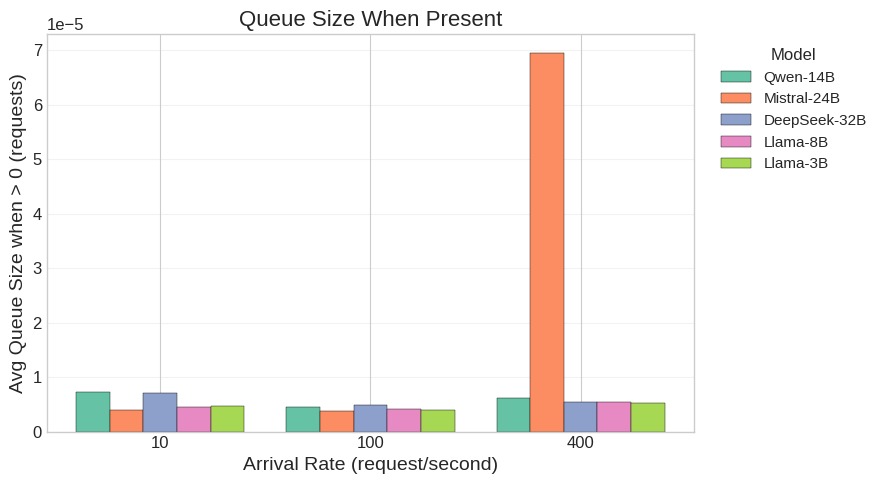

In [39]:
queue_data = step_df.copy()
queue_data['queue_nonzero'] = queue_data['llm_queue_avg'] > 0

queue_stats = (
    queue_data.groupby(['arrival_rate', 'model_short'])
    .agg(
        queue_mean_nonzero=('llm_queue_avg', lambda s: s[s > 0].mean() if (s > 0).any() else 0.0),
    )
    .reset_index()
)

arrival_rates = sorted(queue_stats['arrival_rate'].dropna().unique())
model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']
model_order = [m for m in model_order if m in set(queue_stats['model_short'].unique())]
colors = sns.color_palette('Set2', n_colors=len(model_order))

queue_mean = (
    queue_stats.pivot(index='arrival_rate', columns='model_short', values='queue_mean_nonzero')
    .reindex(columns=model_order)
    .reindex(arrival_rates)
)

fig, ax = plt.subplots(figsize=(9, 5))

x = np.arange(len(arrival_rates))
bar_width = 0.8 / max(len(model_order), 1)

for i, model in enumerate(model_order):
    offset = (i - (len(model_order) - 1) / 2) * bar_width
    ax.bar(
        x + offset,
        queue_mean[model].values,
        width=bar_width,
        label=model,
        color=colors[i],
        edgecolor='black',
        linewidth=0.3,
    )

ax.set_xlabel('Arrival Rate (request/second)')
ax.set_ylabel('Avg Queue Size when > 0 (requests)')
ax.set_title('Queue Size When Present')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(r)}' if float(r).is_integer() else f'{r}' for r in arrival_rates])
ax.grid(True, axis='y', alpha=0.25)
ax.legend(title='Model', loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()



## Issue 2: Rigid Synchronization Overhead (Slowest-Agent Bottleneck)
When agents synchronize, the slowest agent sets wall-clock time and creates idle slack for faster agents.



### Figure 3: Slowest-Agent Share of Workflow Time
Each point is a request; higher values mean a single agent dominated the workflow time.



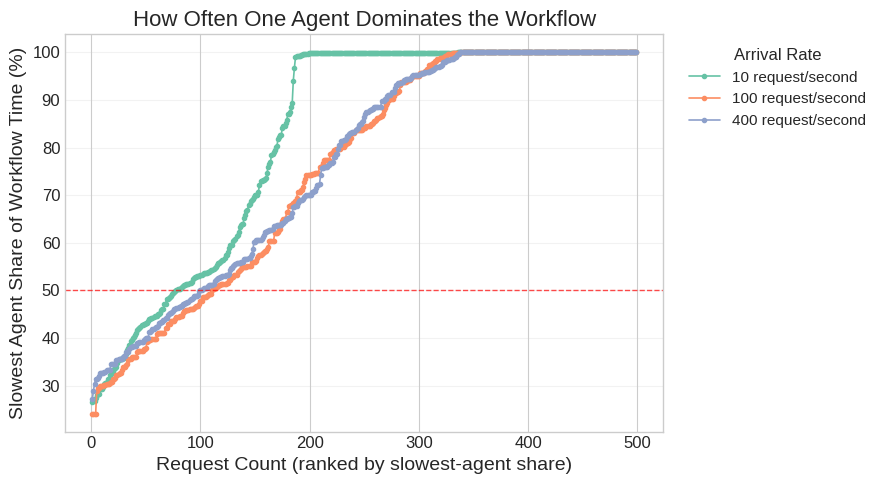

Requests where one agent > 50% of total workflow time:
              requests_over_50pct  total_requests  share_over_50pct
arrival_rate                                                       
10.0                          422             499             84.57
100.0                         389             499             77.96
400.0                         400             499             80.16


In [40]:
wave_keys = ['arrival_rate', 'item_id', 'round_index', 'wave_index']

step_wave = step_df.dropna(subset=['latency_seconds']).copy()

if step_wave.empty:
    print('No latency data available to compute slowest-agent share.')
else:
    idx = step_wave.groupby(wave_keys)['latency_seconds'].idxmax()
    wave_stragglers = (
        step_wave.loc[idx, wave_keys + ['role_name', 'latency_seconds']]
        .rename(columns={'role_name': 'straggler_role', 'latency_seconds': 'wave_duration'})
    )

    workflow_time = (
        wave_stragglers.groupby(['arrival_rate', 'item_id'])['wave_duration']
        .sum()
        .reset_index(name='workflow_time_seconds')
    )

    role_time = (
        wave_stragglers.groupby(['arrival_rate', 'item_id', 'straggler_role'])['wave_duration']
        .sum()
        .reset_index(name='straggler_role_time')
    )

    role_time = role_time.merge(workflow_time, on=['arrival_rate', 'item_id'], how='left')
    role_time['share_pct'] = np.where(
        role_time['workflow_time_seconds'] > 0,
        role_time['straggler_role_time'] / role_time['workflow_time_seconds'] * 100.0,
        0.0,
    )

    slowest_share = (
        role_time.groupby(['arrival_rate', 'item_id'])['share_pct']
        .max()
        .reset_index(name='slowest_agent_share_pct')
    )

    arrival_rates = sorted(slowest_share['arrival_rate'].dropna().unique())
    colors = sns.color_palette('Set2', n_colors=len(arrival_rates))

    fig, ax = plt.subplots(figsize=(9, 5))
    for i, arrival in enumerate(arrival_rates):
        shares = (
            slowest_share[slowest_share['arrival_rate'] == arrival]['slowest_agent_share_pct']
            .sort_values()
            .reset_index(drop=True)
        )
        if shares.empty:
            continue
        x = np.arange(1, len(shares) + 1)
        ax.plot(
            x,
            shares.values,
            marker='o',
            markersize=3,
            linewidth=1.2,
            label=f'{int(arrival) if float(arrival).is_integer() else arrival} request/second',
            color=colors[i],
        )

    ax.axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel('Request Count (ranked by slowest-agent share)')
    ax.set_ylabel('Slowest Agent Share of Workflow Time (%)')
    ax.set_title('How Often One Agent Dominates the Workflow')
    ax.legend(title='Arrival Rate', loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.grid(True, axis='y', alpha=0.25)

    plt.tight_layout()
    plt.show()

    dominant_counts = (
        slowest_share.assign(over_50=slowest_share['slowest_agent_share_pct'] > 50)
        .groupby('arrival_rate')['over_50']
        .sum()
    )
    total_counts = slowest_share.groupby('arrival_rate')['item_id'].nunique()
    dominant_summary = pd.DataFrame({
        'requests_over_50pct': dominant_counts,
        'total_requests': total_counts,
    })
    dominant_summary['share_over_50pct'] = (
        dominant_summary['requests_over_50pct'] / dominant_summary['total_requests'] * 100.0
    )

    print('Requests where one agent > 50% of total workflow time:')
    print(dominant_summary.round(2))



### Figure 4: Slack Opportunity per Role vs Arrival Rate
Slack is shown per role (not stacked) to make each role's idle opportunity visible.



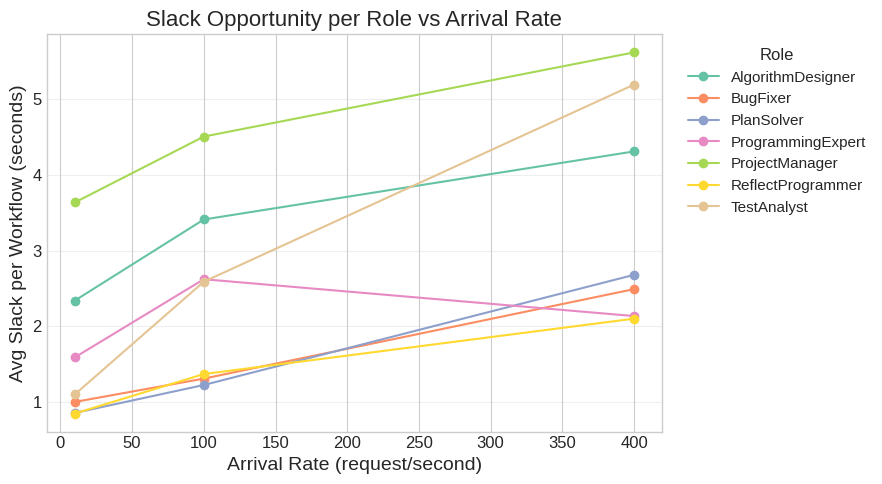

In [41]:
fig, ax = plt.subplots(figsize=(9, 5))

step_slack = step_df.copy()
if 'wave_slack_seconds' not in step_slack.columns:
    step_slack['wave_slack_seconds'] = 0.0

episode_counts = episode_df.groupby('arrival_rate')['item_id'].nunique()
slack_by_role = (
    step_slack.groupby(['arrival_rate', 'role_name'])['wave_slack_seconds']
    .sum()
    .unstack(fill_value=0)
)
slack_by_role = slack_by_role.div(episode_counts, axis=0).fillna(0.0)

role_order = sorted([r for r in step_slack['role_name'].dropna().unique()])
slack_by_role = slack_by_role.reindex(columns=role_order).sort_index()
colors = sns.color_palette('Set2', n_colors=len(role_order))

for i, role in enumerate(role_order):
    ax.plot(
        slack_by_role.index,
        slack_by_role[role],
        marker='o',
        linewidth=1.5,
        label=role,
        color=colors[i],
    )

ax.set_xlabel('Arrival Rate (request/second)')
ax.set_ylabel('Avg Slack per Workflow (seconds)')
ax.set_title('Slack Opportunity per Role vs Arrival Rate')
ax.legend(title='Role', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

